# Final Project

Student 1: Alejandro González Álvarez

NIA 1: 252658

Student 2: Luca Franceschi

NIA 2: 253885

Student 3: Júlia Othats-Dalès

NIA 3: 254435

In [1]:
# ideas

'''
classification of doppelgangers: to which person are you more alike?

input: one facial image
output: closest face in the feature space

pretrained model for image recognition?
triplet loss?
siamese network?

use transfer learning or train with vggface2?
fine tune with smaller dataset of doppelgangers

contrastive learning
https://encord.com/blog/guide-to-contrastive-learning/
https://www.v7labs.com/blog/contrastive-learning-guide
https://arxiv.org/pdf/1512.03385
https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/
https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
https://www.v7labs.com/blog/triplet-loss
https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html
https://medium.com/@Skpd/triplet-loss-on-imagenet-dataset-a2b29b8c2952
https://omoindrot.github.io/triplet-loss
https://arxiv.org/pdf/1503.03832v3
'''

'\nclassification of doppelgangers: to which person are you more alike?\n\ninput: one facial image\noutput: closest face in the feature space\n\npretrained model for image recognition?\ntriplet loss?\nsiamese network?\n\nuse transfer learning or train with vggface2?\nfine tune with smaller dataset of doppelgangers\n\ncontrastive learning\nhttps://encord.com/blog/guide-to-contrastive-learning/\nhttps://www.v7labs.com/blog/contrastive-learning-guide\nhttps://arxiv.org/pdf/1512.03385\nhttps://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/\nhttps://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py\nhttps://www.v7labs.com/blog/triplet-loss\nhttps://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html\nhttps://medium.com/@Skpd/triplet-loss-on-imagenet-dataset-a2b29b8c2952\nhttps://omoindrot.github.io/triplet-loss\nhttps://arxiv.org/pdf/1503.03832v3\n'

In [2]:
import json
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
import scipy.io as sio
from torchinfo import summary
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights

/home/lukovsky/Documents/repos/DL-2024/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
# Comment if not in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = '/content/drive/My Drive/DeepLearning_2024/P4/Data/'
# results_path = '/content/drive/My Drive/DeepLearning_2024/P4/Results/'

# Comment if in Google Colab
data_path = 'data/'
results_path = 'results/'

In [4]:
# Print if gpu acceleration is enabled
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
fixed_seed = 42

# The HDA Doppelgaenger Dataset

In [6]:
class HDA_Doppelgaenger(torch.utils.data.Dataset):

    def __init__(self, datadir = data_path, transform = None, dataset_version = 'dataset.json', seed = None):

        self.datadir = datadir
        self.transform = transform
        if seed != None:
            np.random.seed(seed)

        with open('./' + dataset_version, 'r') as fp:
            self.indexer = json.load(fp)['HDA_Doppelgaenger']

    def __getitem__(self, index):
        neg_idx = np.random.randint(0, len(self.indexer)) # index
        neg_type = np.random.choice([0, 1]) # original or lookalike

        anchor = Image.open(self.datadir + self.indexer[index][0])
        positive = Image.open(self.datadir + self.indexer[index][1])
        negative = Image.open(self.datadir + self.indexer[neg_idx][neg_type])

        if self.transform is not None :
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative
    
    def __len__(self):
        return len(self.indexer)
    
    def mean(self):
        sum = np.zeros(3)
        for i in range(len(self)):
            sum += np.array(self[i][0]).sum(axis=(0,1))
            sum += np.array(self[i][1]).sum(axis=(0,1))
        return sum / (len(self)*2) / 255 / 256**2
    
    def mean_std(self):
        mean = self.mean()

        sum = np.zeros(3)
        for i in range(len(self)):
            sum += np.power(np.array(self[i][0]), 2).sum(axis=(0,1))
            sum += np.power(np.array(self[i][1]), 2).sum(axis=(0,1))
        sum = sum / (len(self)*2) / 255 / 256**2
        
        return mean, np.sqrt(sum - np.power(mean, 2))

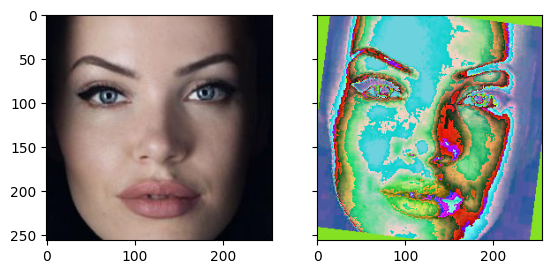

In [7]:
dataset = HDA_Doppelgaenger(dataset_version='F_dataset.json')

HDA_mean, HDA_std = dataset.mean_std()

base_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(HDA_mean, HDA_std)])

augm_transform = transforms.Compose(
     [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomGrayscale(0.2),
     transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
     transforms.RandomAffine(45),
     transforms.ToTensor(),
     transforms.Normalize(HDA_mean, HDA_std)])

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

axs[0].imshow(dataset[0][1])
dataset.transform = augm_transform

toimage = transforms.ToPILImage()
axs[1].imshow(toimage(dataset[0][1]))
plt.show()

## Mean and Standard Deviation of the dataset

# Dataloaders

In [8]:
reduction = 10 # the batches' size will be = len(dataset) / reduction

generator = torch.Generator().manual_seed(fixed_seed) # to have reproducible results
train, validation, test = random_split(dataset, [0.85, 0.1, 0.05], generator=generator)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=int(len(train)/reduction), shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation, batch_size=int(len(validation)/reduction), shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=int(len(test)/reduction), shuffle=True)

# ResNet-18

This is our re-implementation of the ResNet-18 architecture extracted from [the torchvision github repository](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py). We believe that it is important to note that it is not a simple copy-paste, we have put our best efforts in understanding and re-implementing it to fufill our needs.

## Basic ResNet building block

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(ResidualBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = norm_layer(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False) # in this one stride = 1 then image shape is kept
        self.bn2 = norm_layer(planes)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x): # Tip for improving performance merge all into one line relu(bn2(conv2(relu(bn1(conv1(x))))))
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

## ResNet Architecture

In [10]:
class ResNet(nn.Module):

    def __init__(self, layers, num_classes=1000, zero_init_residual=False, norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        # Introduction layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layer(64, 64, layers[0])
        self.layer2 = self._make_layer(64, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(128, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(256, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Last fully connected layer
        self.fc = nn.Linear(512, num_classes)

        # What is going on ???
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        # if zero_init_residual:
        #     for m in self.modules():
        #         if isinstance(m, Bottleneck):
        #             nn.init.constant_(m.bn3.weight, 0)
        #         elif isinstance(m, BasicBlock):
        #             nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, in_planes, out_planes, blocks, stride=1):
        '''
        Creates a layer containing {blocks} ResidualBlocks, where the first one downsamples the output if needed,
        and the next {blocks-1} stacked blocks keep the amount of filters unaltered.
        '''
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or in_planes != out_planes:
            downsample = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                norm_layer(out_planes)
            )

        layers = []
        layers.append(ResidualBlock(in_planes, out_planes, stride, downsample, norm_layer))

        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_planes, out_planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        return x

In [11]:
summary(ResNet([2, 2, 2, 2], 1000), input_size=(128,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 512, 1, 1]          513,000
├─Conv2d: 1-1                            [128, 64, 128, 128]       9,408
├─BatchNorm2d: 1-2                       [128, 64, 128, 128]       128
├─ReLU: 1-3                              [128, 64, 128, 128]       --
├─MaxPool2d: 1-4                         [128, 64, 64, 64]         --
├─Sequential: 1-5                        [128, 64, 64, 64]         --
│    └─ResidualBlock: 2-1                [128, 64, 64, 64]         --
│    │    └─Conv2d: 3-1                  [128, 64, 64, 64]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 64, 64]         128
│    │    └─ReLU: 3-3                    [128, 64, 64, 64]         --
│    │    └─Conv2d: 3-4                  [128, 64, 64, 64]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 64, 64]         128
│    │    └─ReLU: 3-6                    [128, 64, 64, 64]        

## How pretrained weights are loaded

In [12]:
pretrained_weights = ResNet18_Weights.DEFAULT.get_state_dict()
net = ResNet([2, 2, 2, 2]).to(device)
net.load_state_dict(pretrained_weights)
# TRY WITH fishernet vgg16
net.fc = None

# Early Stopper

In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, net, validation_loss, model_name):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

            # save trained model
            torch.save(net.state_dict(), results_path + model_name)

        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Training function

In [14]:
def validate(net, val_loader):
    net.eval()

    loss_list = []

    criterion = nn.TripletMarginLoss()

    val_loss_epoch = 0

    for anchors, positives, negatives in val_loader: # batches of positive, negative and anchor images

        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)

        out_anc = net(anchors)
        out_pos = net(positives)
        out_neg = net(negatives)

        loss = criterion(out_anc, out_pos, out_neg)

        val_loss_epoch += loss.cpu().item()
        
        loss_list.append(loss.cpu().item())

    return val_loss_epoch / len(val_loader), loss_list

In [15]:
def fit(net, tr_loader, val_loader, epochs=10, optimizer=None, model_name='default.ckpt'):
    
    net.train()
    
    loss_list = {
        'training': [],
        'validation': []
    }

    criterion = nn.TripletMarginLoss()

    early_stopper = EarlyStopper(patience=3, min_delta=0.1)

    for e in range(0, epochs):

        loss_list['training'].append([])
        loss_list['validation'].append([])

        tr_loss_epoch = 0

        for anchors, positives, negatives in tr_loader: # batches of positive, negative and anchor images

            anchors = anchors.to(device)
            positives = positives.to(device)
            negatives = negatives.to(device)

            out_anc = net(anchors)
            out_pos = net(positives)
            out_neg = net(negatives)

            loss = criterion(out_anc, out_pos, out_neg)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_loss_epoch += loss.cpu().item()
            
            loss_list['training'][e].append(loss.cpu().item())

        tr_loss_epoch /= len(tr_loader)

        val_loss_epoch, val_loss_list = validate(net, val_loader)
        loss_list['validation'][e] = val_loss_list

        print('Epoch [{:4n}/{:4n}] | Train Loss: {:.4f} | Validation Loss: {:4n}'.format(e+1, epochs, tr_loss_epoch, val_loss_epoch))

        if early_stopper.early_stop(net, val_loss_epoch, model_name):
            return loss_list
        
    return loss_list

# Test function

In [16]:
def test(net, test_loader):
    
    for anchor, positive, negative in test_loader: # batches of positive, negative and anchor images

        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        out_anc = net(anchor).flatten().detach().cpu().numpy()
        out_pos = net(positive).flatten().detach().cpu().numpy()
        out_neg = net(negative).flatten().detach().cpu().numpy()

        near = np.linalg.norm(out_anc - out_pos, 2)
        far = np.linalg.norm(out_anc - out_neg, 2)

        # TODO: PRINT IMAGES, LATENT SPACE, ETC --> BASICALLY TEST IS FOR VISUALIZATION OF SPECIFIC RESULTS

        print('Doppelgaengers: {:.4f}, Non doppelgaengers: {:.4f}'.format(near, far))

# Training Loop

In [21]:
learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay=1e-5)
list_loss = fit(net, train_loader, validation_loader, 10, optimizer=optimizer)

sio.savemat(results_path + 'list_loss.mat', list_loss)

Epoch [   1/  10] | Train Loss: 0.9942 | Validation Loss: 1.04225
Epoch [   2/  10] | Train Loss: 1.0190 | Validation Loss: 1.01382
Epoch [   3/  10] | Train Loss: 0.9985 | Validation Loss: 1.04031
Epoch [   4/  10] | Train Loss: 1.0031 | Validation Loss: 0.992813
Epoch [   5/  10] | Train Loss: 1.0102 | Validation Loss: 1.00074
Epoch [   6/  10] | Train Loss: 1.0064 | Validation Loss: 1.00166
Epoch [   7/  10] | Train Loss: 0.9995 | Validation Loss: 1.00191
Epoch [   8/  10] | Train Loss: 1.0003 | Validation Loss: 0.999288
Epoch [   9/  10] | Train Loss: 1.0007 | Validation Loss: 0.999553
Epoch [  10/  10] | Train Loss: 0.9999 | Validation Loss: 0.99877


In [18]:
# loadedDict = {}
# sio.loadmat('list_loss.mat', loadedDict)

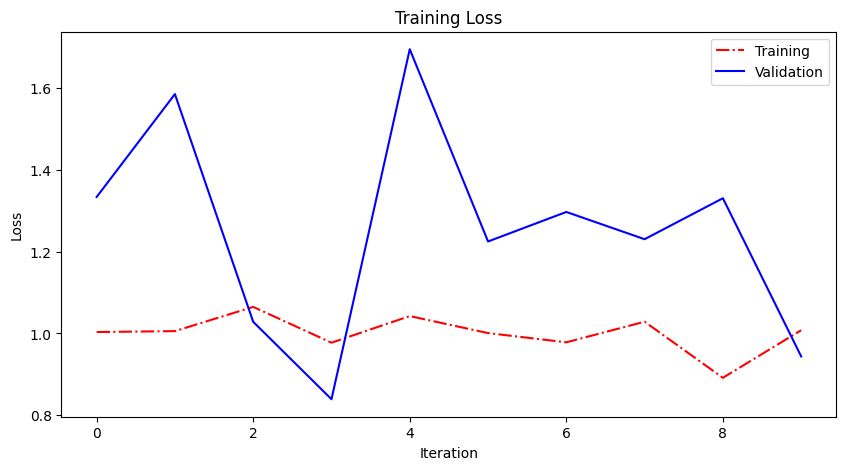

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(list_loss['training'][0], linestyle='-.', color='r', label='Training')
plt.plot(list_loss['validation'][0], linestyle='-', color='b', label='Validation')
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
test(net, test_loader)

Doppelgaengers: 0.7690, Non doppelgaengers: 0.7116
Doppelgaengers: 0.9872, Non doppelgaengers: 0.8751
Doppelgaengers: 0.1549, Non doppelgaengers: 0.6186
Doppelgaengers: 0.4343, Non doppelgaengers: 1.0267
Doppelgaengers: 1.6960, Non doppelgaengers: 1.9751
Doppelgaengers: 0.1691, Non doppelgaengers: 1.0556
Doppelgaengers: 1.1245, Non doppelgaengers: 0.1760
Doppelgaengers: 0.3932, Non doppelgaengers: 0.4488
Doppelgaengers: 0.3139, Non doppelgaengers: 0.7793
Doppelgaengers: 0.4415, Non doppelgaengers: 0.2353
